In [ ]:
#16
from tensorflow.keras.datasets import mnist

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report , accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
(X_train, y_train), (X_test, y_test)= mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [ ]:
X_train = X_train.reshape(-1,28*28).astype(np.float32)
X_test = X_test.reshape(-1,28*28).astype(np.float32)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

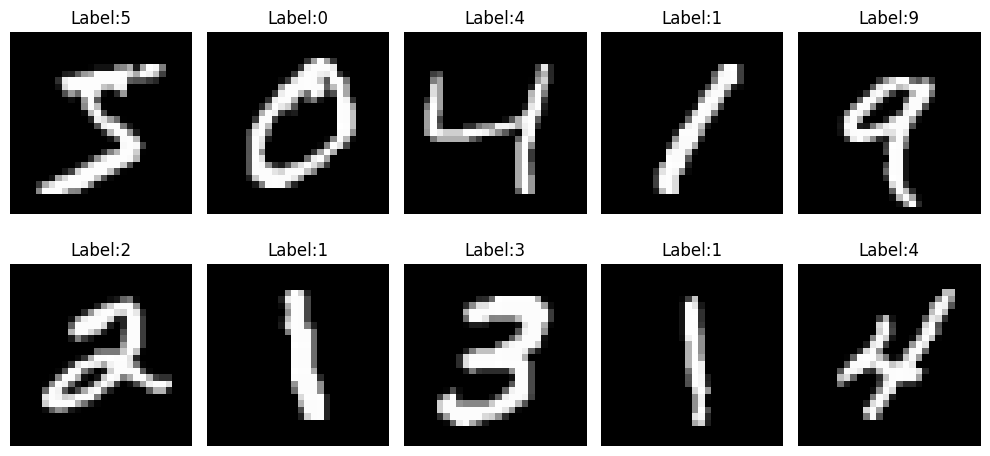

In [ ]:
fig , axes = plt.subplots(2,5, figsize=(10,5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_train[i].reshape(28,28), cmap='gray')
    ax.set_title(f"Label:{y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
clf =LinearSVC(dual=False, max_iter=10)
clf.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=False, max_iter=10)

In [ ]:
y_pred = clf.predict(X_test_scaled)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9163


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.95      0.98      0.96      1135
           2       0.93      0.88      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.93      0.92       982
           5       0.88      0.86      0.87       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.87      0.86      0.87       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.91     10000
weighted avg       0.92      0.92      0.92     10000



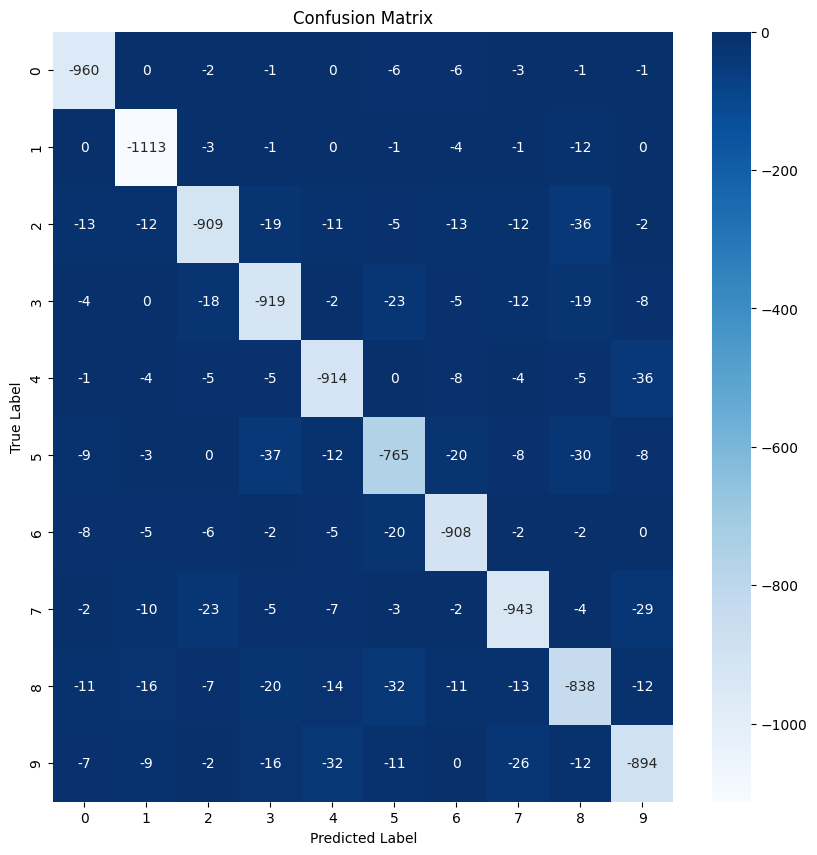

In [ ]:
import seaborn as sns
cm =- confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

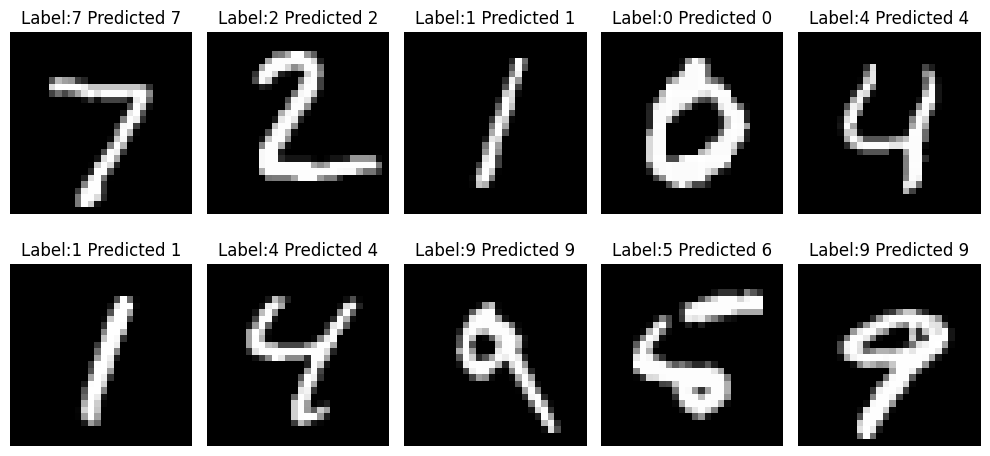

In [ ]:
fig , axes = plt.subplots(2,5, figsize=(10,5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_test[i].reshape(28,28), cmap='gray')
    ax.set_title(f"Label:{y_test[i]} Predicted {y_pred[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#misidebntification
misclassified_indices = np.where(y_test != y_pred)[0]

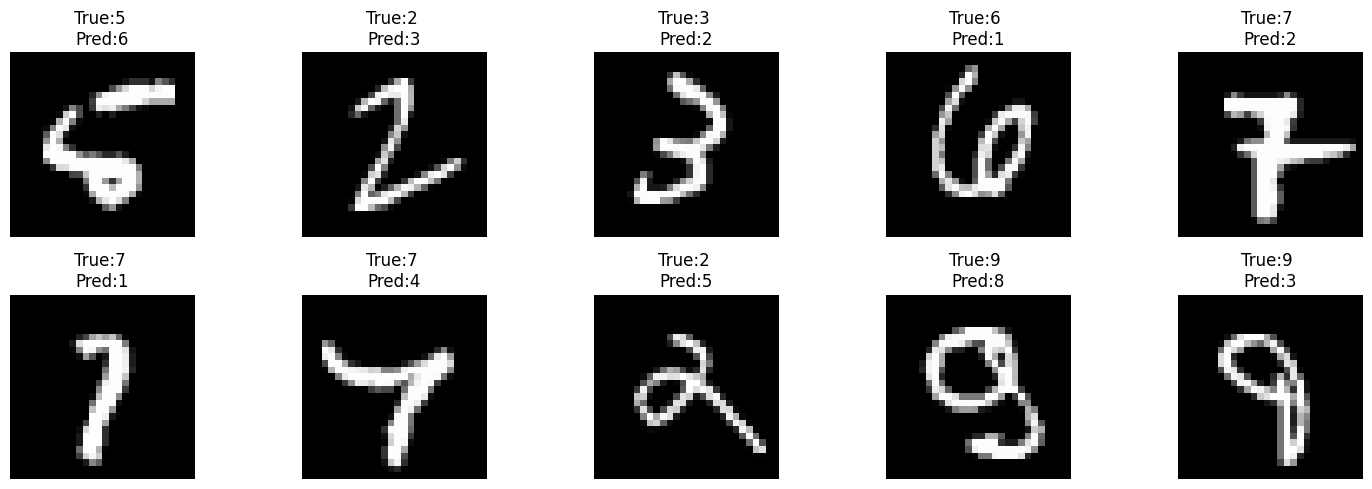

In [ ]:
plt.figure(figsize=(15,5))
for i , index in enumerate(misclassified_indices[:10]):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[index].reshape(28,28), cmap='gray')
    plt.title(f"True:{y_test[index]} \nPred:{y_pred[index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
weights = clf.coef_
biases = clf.intercept_
print(weights.shape, biases)

(10, 784) [-2.95258928 -3.69349937 -1.80956589 -1.98311729 -2.72051569 -1.88057748
 -2.71084417 -3.07406188 -1.5869174  -2.36302348]


In [ ]:
max_val = np.abs(weights).max()
scale = max_val / 127.0
weights_int8 = np.round(weights / scale).astype(np.int8)
with open("svm_model.h","w") as f:
  f.write(f"#define NUM_CLASSES {weights.shape[0]}\n")
  f.write(f"#define NUM_FEATURES {weights.shape[1]}\nn")
  f.write(f"const float wieghts_scale = {scale:.10f};\n\n")

  f.write("in8_t weights[NUM_CLASSES][NUM_FEATURES] = {\n")
  for row in weights_int8:
    f.write("   {" + ",".join (str(v) for v in row ) + "},\n")
  f.write("};\n\n")
  f.write("double bias[NUM_CLASSES] = {" + ",".join (str(b) for b in biases ) + "};\n")
print("Exported svm_model to svm_model.h")

Exported svm_model to svm_model.h


In [ ]:
mean = scaler.mean_
max_mean = np.abs(mean).max()
scale = max_mean / 127.0
mean_int8 = np.round(mean / scale).astype(np.int8)
op_scale = scaler.scale_
max_scale= np.abs(op_scale).max
scale = max_mean / 127.0
scale_int8 = np.round(op_scale / scale).astype(np.int8)
with open ("scaler.h","w") as f:
   f.write(f"#define NUM_FEATURES {len(mean)}\n\n")

   f.write("int8_t mean[NUM_FEATURES] = {\n")
   f.write("   {" + ",".join (str(m) for m in mean_int8 ) + "\n};\n\n")

   f.write("int8_t mean[NUM_FEATURES] = {\n")
   f.write("   {" + ",".join (str(s) for s in scale_int8 ) + "\n};\n")

print("Exported scaler parameter to scalar.h")


Exported scaler parameter to scalar.h


In [ ]:
NUM_IMAGES_TO_EXPORT = 10

In [ ]:
assert X_test.shape[1] ==784
X_sample = X_test[:NUM_IMAGES_TO_EXPORT]
y_sample = y_test[:NUM_IMAGES_TO_EXPORT]

In [ ]:
def export_test_images_to_c(images,labels,filename="test_images.h"):
  num_images, num_features = images.shape
  images_int8 = images.astype(np.int8)
  with open(filename,"w") as f:
    f.write(f"#ifndef TEST_IMAGES_H\ndefine TEST_IMAGES_H\n\n")
    f.write(f"#define NUM_TEST_IMAGES {num_images}\n")
    f.write(f"#define NUM_TEST_FEATURES {num_features}\n\n")

    f.write("float test_images[NUM_TEST_IMAGES][NUM_TEST_FEATURES] = {\n")
    for img in images:
      f.write("   {" + ",".join(f"{px}" for px in img) + "},\n")
    f.write("};\n\n")

    f.write(f"int test_labels[NUM_TEST_IMAGES] = {{")
    f.write(",".join(str(label) for label in labels ))
    f.write("};\n\n")
    f.write("#endif // TEST_IMAGES_H\n")
  print(f"Exported {num_images} test images to {filename}")

In [ ]:

export_test_images_to_c(X_sample, y_sample,"test_images.h")

Exported 10 test images to test_images.h
